In [1]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.9 MB/s 


In [2]:
from google.colab import files

In [3]:
import numpy as np
import pandas as pd
import json, os
import matplotlib.pyplot as plt 
from matplotlib import colors
from PIL import Image
import io
import random
import copy
import pickle

In [ ]:
files.upload()

In [ ]:
class ARC():
    def __init__(self,trn_dir='./training_orig/',tes_dir='./test_eval/'):
        pass
    def plot_task(self,task,kind='orig',show=True,ways=4):
        # Call with ways=4 for padded case and ways=6 for unpadded case
        n = len(task["train"]) + len(task["test"])
        if kind=='orig':fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
        elif kind=='fewshot': fig, axs = plt.subplots(ways+1, n, figsize=(6*n,12), dpi=100)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig_num = 0
        cmap=self.cmap
        norm=self.norm
        for i, t in enumerate(task["train"]):
            if kind=='fewshot':t_in, t_out = np.array(t["input"]), t["output"]
            elif kind=='orig':t_in, t_out = np.array(t["input"]), np.array(t["output"])
            axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
            axs[0][fig_num].set_title(f'Train-{i} in')
            # axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
            # axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
            if kind=='orig':
                axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
                axs[1][fig_num].set_title(f'Train-{i} out')
                # axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
                # axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
            elif kind=='fewshot':
                for j in range(ways):
                    if j==t['label']: iscorrect='CORRECT'
                    else: iscorrect=''
                    axs[j+1][fig_num].imshow(np.array(t_out[j]), cmap=cmap, norm=norm)
                    axs[j+1][fig_num].set_title(f'Out-{i},{j} '+iscorrect)
                    # axs[j+1][fig_num].set_yticks(list(range(np.array(t_out[j]).shape[0])))
                    # axs[j+1][fig_num].set_xticks(list(range(np.array(t_out[j]).shape[1])))
            fig_num += 1
        for i, t in enumerate(task["test"]):
            if kind=='fewshot':t_in, t_out = np.array(t["input"]), t["output"]
            elif kind=='orig':t_in, t_out = np.array(t["input"]), np.array(t["output"])
            axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
            axs[0][fig_num].set_title(f'Test-{i} in')
            # axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
            # axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
            if kind=='orig' and show:
                axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
                axs[1][fig_num].set_title(f'Test-{i} out')
                # axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
                # axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
            elif kind=='fewshot' and show:
                for j in range(ways):
                    if j==t['label']: iscorrect='CORRECT'
                    else: iscorrect=''
                    axs[j+1][fig_num].imshow(np.array(t_out[j]), cmap=cmap, norm=norm)
                    axs[j+1][fig_num].set_title(f'Test-{i},{j} '+iscorrect)
                    # axs[j+1][fig_num].set_yticks(list(range(np.array(t_out[j]).shape[0])))
                    # axs[j+1][fig_num].set_xticks(list(range(np.array(t_out[j]).shape[1])))
            fig_num += 1
        plt.tight_layout()
        plt.show()
    def example2img(self,example):
        shp=np.array(example).shape
        fig=plt.Figure(figsize=(.5*shp[0],.5*shp[1]))
        ax = fig.add_subplot()
        cmap,norm=self.cmap,self.norm
        ax.imshow(np.array(example), cmap=cmap, norm=norm)
        """Convert a Matplotlib figure to a PIL Image and return it"""
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img
    def example2numpy(self,example):
        return np.array(example)

In [ ]:
class FewShotARC(ARC):
    def __init__(self,trn_dir='./training_orig/',tes_dir='./test_eval/',ways=6):
        super().__init__(trn_dir='./training_orig/',tes_dir='./test_eval/')
        self.nrand=ways-1
        self.ntrain=len(self.trn_tasks)
        self.ntest=len(self.tes_tasks)
        self.meta_train_tasks=[]
        self.meta_test_tasks=[]
    def get_fs_task(self,taskid,kind='meta_train'):
        if kind=='meta_train': return self.meta_train_tasks[taskid]
        elif kind=='meta_test': return self.meta_test_tasks[taskid]
    def get_examples(self,taskid,trte,inout,kind='meta_train'):
        if kind=='meta_train':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        elif kind=='meta_test':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        return [taskL[taskid][trte][k][inout] for k in range(len(taskL[taskid][trte]))]

In [ ]:
class FewShotPaddedARC(ARC):
    def __init__(self,trn_dir='./training_orig/',tes_dir='./test_eval/',ways=6):
        super().__init__(trn_dir='./training_orig/',tes_dir='./test_eval/')
        self.nrand=ways-1
        self.ntrain=len(self.trn_tasks)
        self.ntest=len(self.tes_tasks)
        self.meta_train_tasks=[]
        self.meta_test_tasks=[]
    def get_fs_task(self,taskid,kind='meta_train'):
        if kind=='meta_train': return self.meta_train_tasks[taskid]
        elif kind=='meta_test': return self.meta_test_tasks[taskid]
    def get_examples(self,taskid,trte,inout,kind='meta_train'):
        if kind=='meta_train':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        elif kind=='meta_test':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        return [taskL[taskid][trte][k][inout] for k in range(len(taskL[taskid][trte]))]

In [ ]:
with open('./FewShotARC.pickle','rb') as f: a=pickle.load(f)

In [ ]:
a.cmap=colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00','#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

In [ ]:
a.norm=colors.Normalize(vmin=0, vmax=9)

In [ ]:
task=a.get_fs_task(11)

In [ ]:
task['train'][0].keys()

In [ ]:
a.plot_task(task,kind='fewshot')

In [ ]:
with open('./FewShotPaddedARC.pickle','rb') as f: b=pickle.load(f)

In [ ]:
b.cmap=colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00','#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

In [ ]:
b.norm=colors.Normalize(vmin=0, vmax=9)

In [ ]:
padded_task=b.get_fs_task(11, kind = "meta_test")

In [ ]:
print(padded_task['test'])

In [ ]:
b.plot_task(padded_task,kind='fewshot')

# Preprocessing


In [ ]:
!pip install learn2learn --quiet
!pip install import_ipynb --quiet

In [ ]:
import requests
import pickle

In [ ]:
#If on colab:
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/utils.ipynb?raw=true")
with open('./utils.ipynb','wb') as f: f.write(r.content)
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/course_data.ipynb?raw=true")
with open('./course_data.ipynb','wb') as f: f.write(r.content)

In [ ]:

r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/l2lutils.ipynb?raw=true")
with open('./l2lutils.ipynb','wb') as f: f.write(r.content)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%ls drive/MyDrive/'Colab Notebooks'

In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/models.ipynb .

In [ ]:
import import_ipynb
import utils
import models
utils.hide_toggle('Imports 1')

In [ ]:
from IPython import display
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display
utils.hide_toggle('Imports 2')

In [ ]:
import random
import torch
class DataLoader():
    def __init__(self, data, train_task, test_task):
        self.data = data
        self.train_task = train_task;
        self.test_task = test_task
    def get_task(self, kind = "meta_train", technique = 2):
        ind = 0
        if(kind == "meta_train"):
            ind = random.randint(0, self.train_task - 1)
        else:
            ind = random.randint(0, self.test_task - 1)
        # print(ind)
        b = self.data.get_fs_task(ind, kind)
        train = b["train"]
        test = b["test"]
        if(technique == 2):
          return self.process(train), self.process(test)
        return self.process2(train), self.process2(test)
    def process(self, batch):
        pair_list, pair_label = [], []
        for ind, sample in enumerate(batch):
            if("label" not in sample):
                continue
            train = sample["input"]
            label = sample["label"]
            test = sample["output"]
            train_torch = torch.FloatTensor(train)
            train_torch = torch.flatten(train_torch, start_dim = 0)
            # train_torch = torch.unsqueeze(train_torch, 0)
            
            for ind_out, j in enumerate(test):
                if(len(j) == len(train)):
                    test_torch = torch.FloatTensor(j)
                    print(test_torch.shape)
                    test_torch = torch.flatten(test_torch, start_dim = 0)
                    pair_list.append(torch.cat((train_torch, test_torch), 0))
                    pair_label.append(ind_out == label)
        # print(torch.stack(pair_list).shape)
        return (torch.stack(pair_list), torch.LongTensor(pair_label)) 
 predict   def process2(self, batch):
        pair_list, pair_label = [], []
        for ind, sample in enumerate(batch):
            if("label" not in sample):
                continue
            train = sample["input"]
            label = sample["label"]
            test = sample["output"]
            train_torch = torch.FloatTensor(train)
            train_torch = torch.flatten(train_torch, start_dim = 0)
            # train_torch = torch.unsqueeze(train_torch, 0)
            
            for ind_out, j in enumerate(test):
                if(len(j) == len(train)):
                    test_torch = torch.FloatTensor(j)
                    test_torch = torch.flatten(test_torch, start_dim = 0)
                    train_torch = torch.cat((train_torch, test_torch), 0)
            pair_label.append(label)
            pair_list.append(train_torch)
        # print(torch.stack(pair_list).shape)
        return (torch.stack(pair_list), torch.LongTensor(pair_label)) 


In [ ]:
train_tasks = len(b.meta_train_tasks)
test_tasks = len(b.meta_test_tasks)


In [ ]:
loader = DataLoader(b, train_tasks, test_tasks)

In [ ]:
loader.get_task()

# MAML


## technique 1 - clubbing everything together

In [ ]:
ways, input_features = 4, 500

In [ ]:
import learn2learn as l2l
import torch.optim as optim

#net = models.MLP(dims=[20,32,32,ways])
net = models.MLP(dims=[input_features,64,32,ways])
#net = models.RNN(n_classes=3,dim=10,n_layers=2)
maml = l2l.algorithms.MAML(net, lr=5e-3)
#maml = l2l.algorithms.MAML(net0, lr=5e-2)
optimizer = optim.Adam(maml.parameters(),lr=5e-4)
# lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))
lossfn = torch.nn.NLLLoss()

In [ ]:
# Number of epochs, tasks per step and number of fast_adaptation steps 
n_epochs = 150
task_count= 64
fas = 5

In [ ]:
epoch=0
while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 1)
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1
    

In [ ]:
# meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
test_acc = 0.0
task_count = 50
adapt_steps = 5
maml.eval()
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 1)
    learner = maml.clone()
    learner.eval()
    for adapt_step in range(adapt_steps):
        train_preds = learner(d_train[0])
        train_loss = lossfn(train_preds,d_train[1])
        learner.adapt(train_loss)
    test_preds = learner(d_test[0])
    test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
    # Done with a task
#learner.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

## technique 2 - clubbing only pairs (options and input) together, only 2 classes.

In [ ]:
ways, input_features = 2, 200

In [ ]:
import learn2learn as l2l
import torch.optim as optim

#net = models.MLP(dims=[20,32,32,ways])
net = models.MLP(dims=[input_features,64,32,ways])
#net = models.RNN(n_classes=3,dim=10,n_layers=2)
maml = l2l.algorithms.MAML(net, lr=5e-3)
#maml = l2l.algorithms.MAML(net0, lr=5e-2)
optimizer = optim.Adam(maml.parameters(),lr=5e-4)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))

In [ ]:
# Number of epochs, tasks per step and number of fast_adaptation steps 
n_epochs = 250
task_count= 64
fas = 5

In [ ]:
epoch=0
while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 2)
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1
    

In [ ]:
# meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
test_acc = 0.0
task_count = 50
adapt_steps = 5
maml.eval()
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    learner = maml.clone()
    learner.eval()
    for adapt_step in range(adapt_steps):
        train_preds = learner(d_train[0])
        train_loss = lossfn(train_preds,d_train[1])
        learner.adapt(train_loss)
    test_preds = learner(d_test[0])
    test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
    # Done with a task
#learner.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

In [ ]:
ways, input_features = 2, 200

In [ ]:
import learn2learn as l2l
import torch.optim as optim

#net = models.MLP(dims=[20,32,32,ways])
net = models.MLP(dims=[input_features,64,32,ways])
#net = models.RNN(n_classes=3,dim=10,n_layers=2)
maml = l2l.algorithms.MAML(net, lr=5e-3)
#maml = l2l.algorithms.MAML(net0, lr=5e-2)
optimizer = optim.Adam(maml.parameters(),lr=5e-4)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))

In [ ]:
def accuracy(Net,X_test,y_test,verbose=True):
    Net.eval()
    m = 0
    y_pred = Net(X_test)
    prob, predicted = torch.max(y_pred, 1)
    correct = 0;
    for i in range(0, y_test.size(0), 4):
        cnt = 0
        for j in range(4):
              cnt += (y_test[i + j] == predicted[i + j])
        if(cnt == 4):
            correct += 1
        m += 1
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
# Number of epochs, tasks per step and number of fast_adaptation steps 
n_epochs = 250
task_count= 64
fas = 5

In [ ]:
epoch=0
while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 2)
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1
    

In [ ]:
# meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
test_acc = 0.0
task_count = 50
adapt_steps = 5
maml.eval()
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    learner = maml.clone()
    learner.eval()
    for adapt_step in range(adapt_steps):
        train_preds = learner(d_train[0])
        train_loss = lossfn(train_preds,d_train[1])
        learner.adapt(train_loss)
    test_preds = learner(d_test[0])
    test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
    # Done with a task
#learner.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

# CNP


In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/CNP.ipynb .

In [ ]:
from CNP import CNP

In [ ]:
# optimisers from torch
import torch.optim as optim
import torch.nn.functional as F

## technique 1 - clubbing everything together

In [ ]:
ways, input_features = 4, 500

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = CNP(n_features=input_features,n_classes=ways,dims=[64,32],lr=1e-4,n_ways=ways)
lossfn = torch.nn.NLLLoss()
#Meta-testing task loader for later.


In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
epoch=0
n_epochs=500
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 1)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h,_,_ = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)#+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 1)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    h,_,_=net.adapt(d_tr,d_train[1])
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,h)
    test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

## technique 2 - clubbing only pairs (options and input) together, only 2 classes.

In [ ]:
ways, input_features = 2, 200

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = CNP(n_features=input_features,n_classes=ways,dims=[64,32],lr=1e-4,n_ways=ways)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))
#Meta-testing task loader for later.


In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
epoch=0
n_epochs=1000
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 2)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h,_,_ = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)#+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    h,_,_=net.adapt(d_tr,d_train[1])
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,h)
    test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

In [ ]:
ways, input_features = 2, 200

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = CNP(n_features=input_features,n_classes=ways,dims=[64,32],lr=1e-4,n_ways=ways)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))
#Meta-testing task loader for later.


In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = 0
    y_pred = Net(X_test,h)
    prob, predicted = torch.max(y_pred, 1)
    correct = 0;
    for i in range(0, y_test.size(0), 4):
        cnt = 0
        for j in range(4):
              cnt += (y_test[i + j] == predicted[i + j])
        if(cnt == 4):
            correct += 1
        m += 1
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
epoch=0
n_epochs=1000
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=loader.get_task(kind = "meta_train", technique = 2)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h,_,_ = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)#+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    h,_,_=net.adapt(d_tr,d_train[1])
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,h)
    test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

# MAN


In [ ]:
import learn2learn as l2l
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/models.ipynb .
!cp drive/MyDrive/'Colab Notebooks'/MAN.ipynb .

In [ ]:
from MAN import MAN

In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

## technique 1 - clubbing everything together

In [ ]:
ways, input_features = 4, 500

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = MAN(n_classes=ways,dims=[input_features,64,32], num_layers = 2, unrolling_steps = 5, lr=5*1e-4)
lossfn = torch.nn.NLLLoss()

In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
epoch=0
n_epochs=100
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test= loader.get_task(kind = "meta_train", technique = 1)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        # print(d_train0.shape)
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        # print(test/_preds)
        train_preds = net(d_tr,(x_tr,d_train1))
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1) 
        # test_loss += lossfn(train_preds, d_train1)

        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 1)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,(d_tr,d_train[1]))
    test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

## technique 2 - clubbing only pairs (options and input) together, only 2 classes.

In [ ]:
ways, input_features = 2, 200

In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = MAN(n_classes=ways,dims=[200,64,32], num_layers = 2, unrolling_steps = 5, lr=5*1e-4)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))

In [ ]:
epoch=0
n_epochs=100
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test= loader.get_task(kind = "meta_train", technique = 2)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        # print(d_train0.shape)
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        # print(test/_preds)
        train_preds = net(d_tr,(x_tr,d_train1))
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1) 
        # test_loss += lossfn(train_preds, d_train1)

        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,(d_tr,d_train[1]))
    test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

In [ ]:
ways, input_features = 2, 200

In [ ]:
import learn2learn as l2l
import torch.optim as optim

net = MAN(n_classes=ways,dims=[200,64,32], num_layers = 2, unrolling_steps = 5, lr=5*1e-4)
lossfn = torch.nn.NLLLoss(weight = torch.tensor([0.25, 0.75]))

In [ ]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = 0
    y_pred = Net(X_test,h)
    prob, predicted = torch.max(y_pred, 1)
    correct = 0;
    for i in range(0, y_test.size(0), 4):
        cnt = 0
        for j in range(4):
              cnt += (y_test[i + j] == predicted[i + j])
        if(cnt == 4):
            correct += 1
        m += 1
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [ ]:
epoch=0
n_epochs=300
task_count=64
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test= loader.get_task(kind = "meta_train", technique = 2)
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        # print(d_train0.shape)
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        # print(test/_preds)
        train_preds = net(d_tr,(x_tr,d_train1))
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1) 
        # test_loss += lossfn(train_preds, d_train1)

        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

In [ ]:

test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=loader.get_task(kind = "meta_test", technique = 2)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,(d_tr,d_train[1]))
    test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

# Modeling
## Technique 1: 
    - each input image is stacked with all the options and passed to the model as it is. 
    - similarly for test and train data
## Technique 2:
    - each input image is stacked with each option one by one and passed to the model, label assigned to each pair is 1 if the option is the correct one.
    - benefit is that we can think of each pair as the input image and consecutive next of input image.this technique makes model focus only on one option time and ensures that properties captured make sense.

## Accuracy 1:
    - straight away accuracy where each class 0 and 1 is given equal importance.
    - not good accuracy function since 75% of data consists of 0 and it is easier to predict 0 than 1.
    - to handle this size imbalance, i have provided class weights to 1 and 0.
## Accuracy 2:
    - assigning correct answer if all the pairs corresponding to the sample have the correct label attached to it. (even if one is incorrect whole sample is assigned 0)
    - benefit, gives a better view of ones score on the test dataset, how many mcqs model was able to select perfectly.

# Models used:
    - MAML with MLP
    - CNP
    - MAN

# Comparison btw models:
    - MAN was not able to converge well and understand the properties of each task or learning behind each task.
    - CNP did well with great accuracy compared to MAN, it was able to converge faster also.
    - MAML had similar results like CNP, understanding most of the tasks.
# Conclusion:
    - task is tough to solve, with the Meta learning techniques taught in class, even getting a 40+ accuracy was hard for very complex models. 
    - hardness of the task is more related to the lack of data provided to solve it than the understanding of problem.
# Accuracy:
  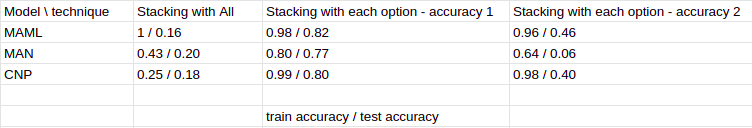


